<h1 style = "font-size:3rem;color:blue;"> Drifter Data Analysis</h1>



Data formatting for Biogeochemical Drifter field observations


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

Read in data and parse by column header


In [3]:
filename = '80010500'

YSIfilename = 'Feb12YSIData'

fullname = filename+'.csv'

YSIfullname = YSIfilename+ '.csv'

filepath = os.path.join('D:', fullname)

YSIfilepath = os.path.join('D:', YSIfullname)


df = pd.read_csv(filepath, parse_dates = [[0, 1]], header = None)

YSIdf = pd.read_csv(YSIfilepath, parse_dates = [[0, 1]], header = None, encoding = 'utf-16', skiprows = 10)
df.columns = ['time', 'elapsed time (sec)', 'lat_raw', 'N or S', 'lon_raw', 'E or W', 'altitude', 'speed', 'angle', 'pH', 'Temperature (C)', 'DO (mg/L)', 'Conductivity (uS/cm)']

YSIdf.columns = ['Time',	'Time (Fract. Sec)',	'Site Name',	'Chlorophyll RFU',	'Cond µS/cm',	'Depth m',	'fDOM QSU',	'fDOM RFU',	'nLF Cond µS/cm',	'ODO % sat',	'ODO % local',	'ODO mg/L',	'Pressure psi a',	'Sal psu',	'SpCond µS/cm',	'TAL PE RFU',	'TDS mg/L',	'Turbidity FNU',	'TSS mg/L',	'pH',	'pH mV',	'Temp °C',	'Vertical Position m',	'GPS Latitude °',	'GPS Longitude °',	'Altitude m',	'Battery V',	'Cable Pwr V',	'Barometer mmHg']
 

df = df.truncate(before = 78, after = None, copy = None)

df.head()

YSIdf.head()



,Time,Time (Fract. Sec),Site Name,Chlorophyll RFU,Cond µS/cm,Depth m,fDOM QSU,fDOM RFU,nLF Cond µS/cm,ODO % sat,...,pH,pH mV,Temp °C,Vertical Position m,GPS Latitude °,GPS Longitude °,Altitude m,Battery V,Cable Pwr V,Barometer mmHg
0,2025-02-12 14:27:25,0.0,<None>,0.63,40023.4,0.440,6.32,2.11,52819.6,101.9,...,6.0,27.2,12.981,0.437,34.14111,-77.86723,17.1,0.0,12.0,761.8
1,2025-02-12 14:27:26,0.0,<None>,0.63,40023.3,0.442,6.51,2.17,52819.4,101.9,...,6.0,27.2,12.981,0.449,34.14111,-77.86723,17.4,0.0,12.0,761.8
2,2025-02-12 14:27:27,0.0,<None>,0.63,40022.8,0.442,6.63,2.21,52818.7,101.9,...,6.0,27.2,12.981,0.448,34.14111,-77.86724,17.4,0.0,12.0,761.8
3,2025-02-12 14:27:28,0.0,<None>,0.63,40022.9,0.441,6.56,2.19,52818.8,101.9,...,6.0,27.2,12.981,0.433,34.14111,-77.86723,17.6,0.0,12.0,761.8
4,2025-02-12 14:27:29,0.0,<None>,0.63,40022.7,0.440,6.46,2.15,52818.6,101.9,...,6.0,27.2,12.981,0.435,34.14111,-77.86724,17.3,0.0,12.0,761.8


In [5]:
def lat_convert(lat_badfmt):
    """Convert latitude from DDDMM.MMMM format to decimal degrees."""
    try:
        lat_badfmt = str(lat_badfmt)
        lat_DD = int(float(lat_badfmt) / 100)  # Extract degrees
        lat_MM = float(lat_badfmt) - lat_DD * 100  # Extract minutes
        return lat_DD + lat_MM / 60  # Convert to decimal degrees
    except ValueError:
        return None  # Return None if conversion fails

def lon_convert(lon_badfmt):
    """Convert longitude from DDDMM.MMMM format to decimal degrees."""
    try:
        lon_badfmt = str(lon_badfmt)
        lon_DD = int(float(lon_badfmt) / 100)  # Extract degrees
        lon_MM = float(lon_badfmt) - lon_DD * 100  # Extract minutes
        return lon_DD + lon_MM / 60  # Convert to decimal degrees
    except ValueError:
        return None  # Return None if conversion fails

# Apply conversions
df['lat'] = df['lat_raw'].apply(lat_convert)
df['lon'] = df['lon_raw'].apply(lon_convert)

# Fix South (negative latitudes)
df.loc[df['N or S'] == 'S', 'lat'] *= -1

# Fix West (negative longitudes)
df.loc[df['E or W'] == 'W', 'lon'] *= -1

# Check output
df.head()


,time,elapsed time (sec),lat_raw,N or S,lon_raw,E or W,altitude,speed,angle,pH,Temperature (C),DO (mg/L),Conductivity (uS/cm),lat,lon
78,2025-02-12 18:53:01.078,158,3408.46777,N,7752.02930,W,5.8,0.28,140.95,8.36,13.81,4.04,46410.0,34.141130,-77.867155
79,2025-02-12 18:53:03.000,160,3408.46753,N,7752.02930,W,6.6,0.35,140.95,8.36,13.81,4.04,46410.0,34.141126,-77.867155
80,2025-02-12 18:53:05.000,162,3408.46753,N,7752.02930,W,7.2,0.43,140.95,8.36,13.81,4.03,46410.0,34.141126,-77.867155
81,2025-02-12 18:53:07.000,164,3408.46729,N,7752.02881,W,7.6,0.38,140.95,8.37,13.81,4.03,46410.0,34.141122,-77.867147
82,2025-02-12 18:53:09.000,166,3408.46704,N,7752.02930,W,7.8,0.25,140.95,8.37,13.82,4.03,46400.0,34.141117,-77.867155


In [7]:
def plot_gps_points(lon, lat):
     fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}) 
     stamen_terrain = cimgt.Stamen('terrain')
     ax.add_image(stamen_terrain, 8)
    
    # Plot the GPS points
     ax.plot(lon, lat, 'bo', markersize=5, transform=ccrs.PlateCarree())
    
    # Add gridlines
     gl = ax.gridlines(draw_labels=True)
     gl.xlabels_top = False
     gl.ylabels_right = False
     gl.xformatter = LONGITUDE_FORMATTER
     gl.yformatter = LATITUDE_FORMATTER
    
     plt.show(df.lon,df.lat)


In [9]:
# Map options: (un)comment blocks corresponding to choice and check to make sure base_layer and tile_zoom are defined
## Stamen
base_layer_stamen = cimgt.Stamen('terrain-background')
tile_zoom_stamen = 12

## Mapbox
map_id = 'satellite-streets-v11'
base_layer_mapbox = cimgt.StadiaMapsTiles(mapbox_access_token, map_id=map_id)
tile_zoom_mapbox = 20

## Open Street Maps
base_layer_OSM = cimgt.OSM()
tile_zoom_OSM = 15
## DEFINE BASE_LAYER AND TILE_ZOOM HERE!
base_layer = base_layer_mapbox
tile_zoom = tile_zoom_mapbox

# Get desired variable
var_name = 'depth (cm)' # selected from columns above
plot_var = df[var_name]
lat = df['lat']
lon = df['lon']

plot_var_min  = min(plot_var) # set manually if desired
plot_var_max  = max(plot_var)
fontsize = 16
# Define CRS
crs = ccrs.PlateCarree() # won't work without this below

## Set plot lims
# Get current corners
lllat = np.nanmin(lat)
lllon = np.nanmin(lon)
urlat = np.nanmax(lat)
urlon = np.nanmax(lon)

# Calculate range in spatial vars
lat_diff = urlat-lllat
lon_diff = urlon-lllon

# How much padding to add--subjective
lat_frac = 0.1
lon_frac = 0.1

# Calculate new plot corners
lllat_plot = lllat-lat_diff*lat_frac
urlat_plot = urlat+lat_diff*lat_frac
lllon_plot = lllon-lon_diff*lon_frac
urlon_plot = urlon+lon_diff*lon_frac

fig = plt.figure(figsize = (16, 16))

# Create a GeoAxes in the tile's projection.
ax = fig.add_subplot(1, 1, 1, projection=base_layer.crs)

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([lllon_plot, urlon_plot, lllat_plot, urlat_plot], crs=crs)

# Add the Stamen data at certain zoom level.
ax.add_image(base_layer, tile_zoom)

# Plot data
sc = plt.scatter(lon, lat, c = 'black', s = 100, transform = crs)
sc = plt.scatter(lon, lat, c = plot_var, s = 75, transform = crs, vmin = plot_var_min, vmax = plot_var_max)
cb = plt.colorbar(sc, extend = 'both')
cb.ax.tick_params(labelsize = fontsize) 
cb.ax.set_title(var_name, fontsize = fontsize)

# Format gridlines
gl = ax.gridlines(crs=crs, draw_labels=True,
                  linewidth=2, color='white', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
# gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': fontsize}#, 'color': 'gray'}
gl.ylabel_style = {'size': fontsize}#, 'color': 'gray'}

figname = filename + var_name+'.png'
figpath = os.path.join('Figs', figname)
# plt.savefig(figpath, dpi = 300) # (un)comment depending on preference for saving figure locally




C:\Users\Stephen\anaconda3\Lib\site-packages\cartopy\io\img_tiles.py:414: UserWarning: The Stamen styles are no longer served by Stamen and are now served by Stadia Maps. Please use the StadiaMapsTiles class instead.
  warnings.warn("The Stamen styles are no longer served by Stamen and "


NameError: name 'mapbox_access_token' is not defined

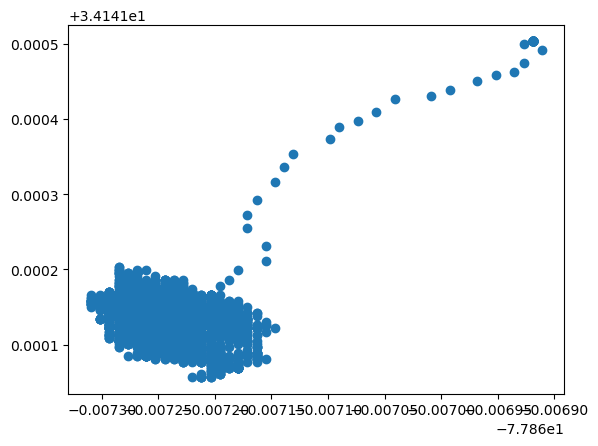

In [49]:
plt.scatter(df.lon, df.lat)


In [27]:
time = df['time']
ph = df['pH']
YSItime = YSIdf['Time']
YSIph = YSIdf['pH']
hours_to_add = 5
YSItime = YSItime + timedelta(hours= hours_to_add)

plt.plot(time,ph)
plt.plot(YSItime,YSIph)
plt.title('pH over time')
plt.xlabel('Time')
plt.ylabel('pH')



NameError: name 'timedelta' is not defined

Text(0, 0.5, 'DO (mg/L)')

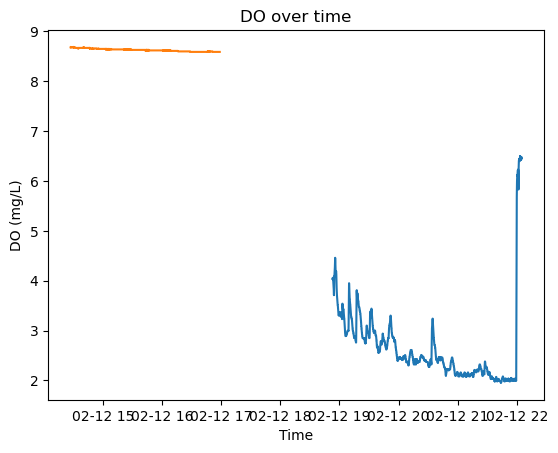

In [17]:
DO = df['DO (mg/L)']
YSIDO = YSIdf['ODO mg/L']

plt.plot(time,DO)
plt.plot(YSItime, YSIDO)
plt.title('DO over time')
plt.xlabel('Time')
plt.ylabel('DO (mg/L)')

Text(0, 0.5, 'Temperature (C)')

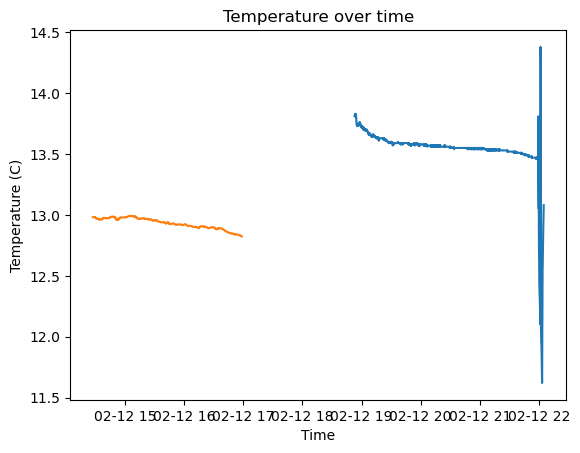

In [23]:
temp = df['Temperature (C)']
YSItemp = YSIdf['Temp °C']

plt.plot(time,temp)
plt.plot(YSItime,YSItemp)
plt.title('Temperature over time')
plt.xlabel('Time')
plt.ylabel('Temperature (C)')

Text(0, 0.5, 'Conductivity (uS/cm)')

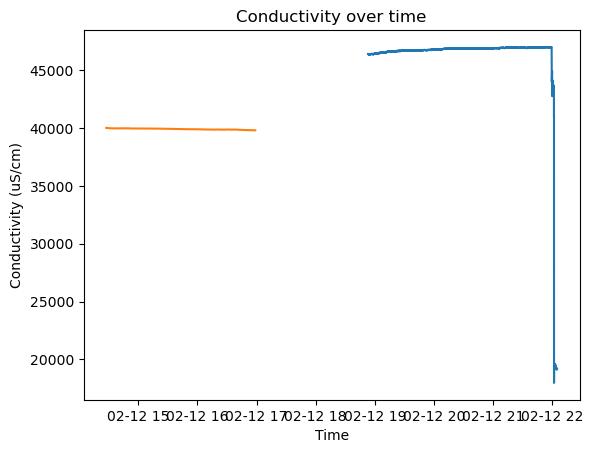

In [25]:
cond = df['Conductivity (uS/cm)']
YSIcond = YSIdf['Cond µS/cm']

plt.plot(time,cond)
plt.plot(YSItime,YSIcond)
plt.title('Conductivity over time')
plt.xlabel('Time')
plt.ylabel('Conductivity (uS/cm)')